In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy

# viz
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
from confusion import make_confusion_matrix



#ml
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 day 11 hours 39 mins
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,"28 days, 6 hours and 40 minutes"
H2O_cluster_name:,H2O_from_python_kenji_n17ewf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.440 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


### The Data

This dataset is taken from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud) and contains 284807 rows of anonymized data represented by 31 numeric features including time, which I will drop as it is not required for this analysis, a binary target feature designated as 'Class', a feature representing dollar amount for each transaction. Rows with a value of 1, of which there are 492, represent fraud while 0 represents non-fraudulent transactions.

### The Models

I chose to start my analysis with the [Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) algorithm which is especially good at finding outliers. As an ensemble method, it randomly selects a feature for each tree's root and also selects a random value along the range of those features values to split upon. The intuition follows that an outlier to the data will require a much shorter path to its isolation, i.e. a pure leaf. The difference between the length of this path and the average depth required by normal data is then computed as the score.

### Exploratory Data Anaysis

In [2]:
df = pd.read_csv('creditcard.csv')

#df.drop('Time', axis = 1, inplace = True)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0, 0.5, 'Frequency')

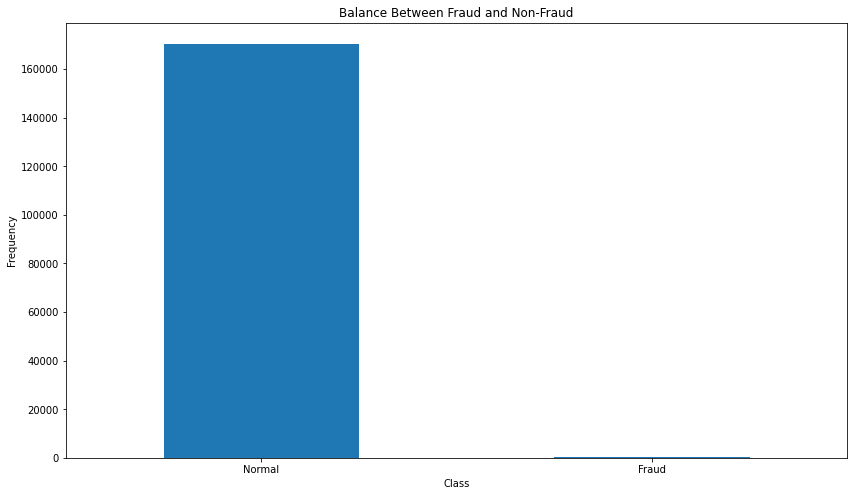

In [3]:
# Checking for missing data or data types that must be accounted for or corrected.
#Fortunately there are none.

balance = pd.value_counts(df['Class'], sort = True)
balance.plot(kind = 'bar', rot=0)
plt.title("Balance Between Fraud and Non-Fraud")
plt.xticks(range(2), ["Normal", "Fraud"])
plt.xlabel("Class")
plt.ylabel("Frequency")

In [4]:
legit_perc = round(sum(df.Class == 0)/len(df)*100,2)
fraud_perc = round(sum(df.Class == 1.0)/len(df)*100,2)

legit_table = df[df['Class'] == 0]
fraud_table = df[df['Class'] == 1]

print(f'Out of {len(df)} records, {sum(df.Class == 1)}, or {fraud_perc}% are labelled as fraudulent while the remaining {sum(df.Class == 0)}, or {legit_perc}% are labelled as non-fraudulent.\nThis gross imbalance also means that special considerations must be made when evaluating the data. Specifically, confusion matrices won\'t\nproperly convery the models\' strength. \nFor that I will experiment with ROC and AUROC as my primary means of evaluating the Isolation Forest algorithm.')

Out of 170885 records, 360, or 0.21% are labelled as fraudulent while the remaining 170525, or 99.79% are labelled as non-fraudulent.
This gross imbalance also means that special considerations must be made when evaluating the data. Specifically, confusion matrices won't
properly convery the models' strength. 
For that I will experiment with ROC and AUROC as my primary means of evaluating the Isolation Forest algorithm.


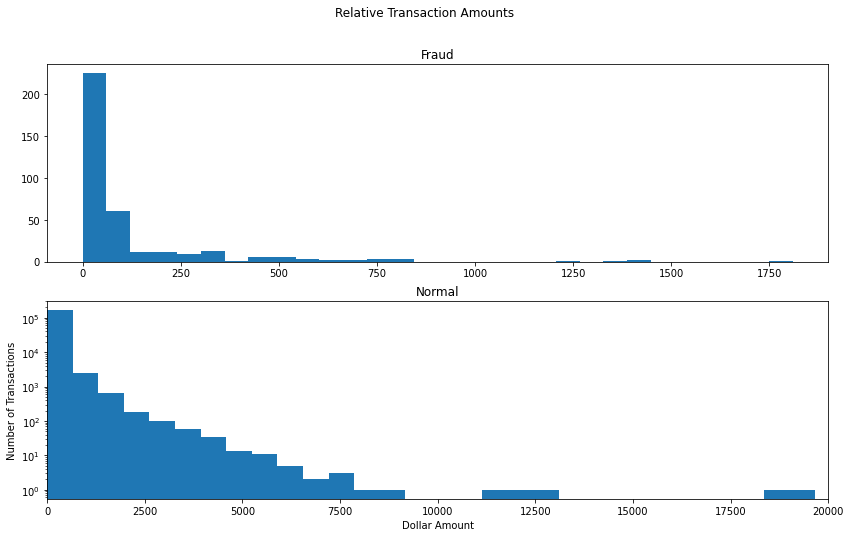

In [5]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=False)
f.suptitle('Relative Transaction Amounts')
bins =30
ax1.hist(fraud_table.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(legit_table.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Dollar Amount')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

#####  A visual comparison of dollar amounts associated with fraudulent vs normal transactions shows that fraud cases overwhelmingly involve small amounts.

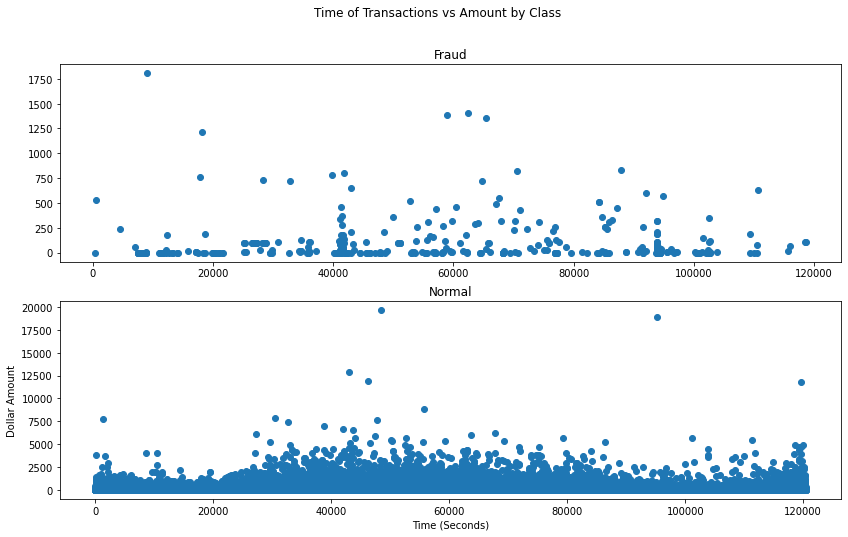

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=False)
f.suptitle('Time of Transactions vs Amount by Class')
ax1.scatter(fraud_table.Time, fraud_table.Amount)
ax1.set_title('Fraud')
ax2.scatter(legit_table.Time, legit_table.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (Seconds)')
plt.ylabel('Dollar Amount')
plt.show()

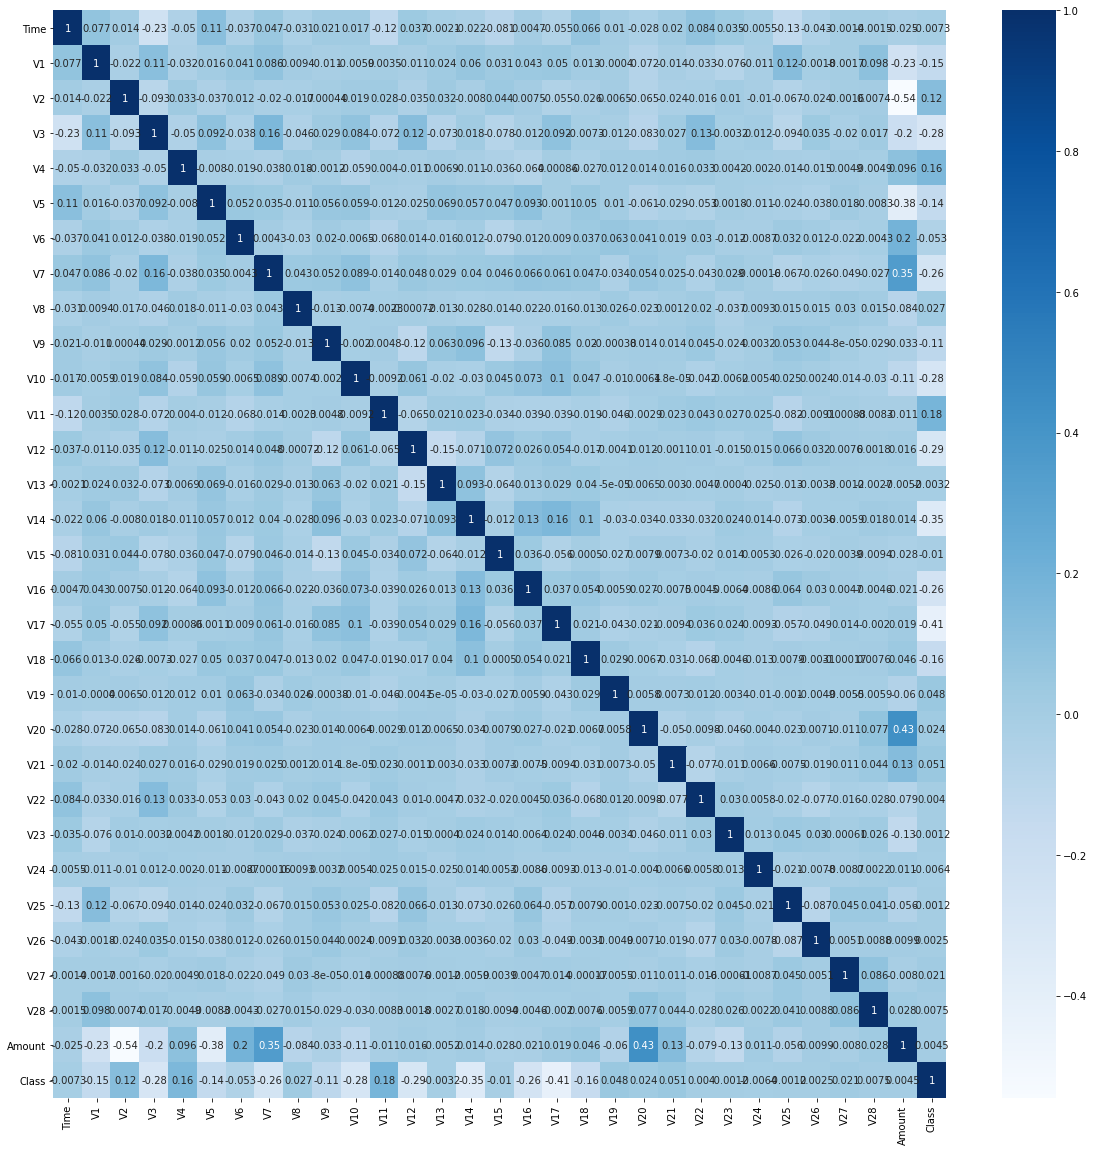

In [7]:
# Getting Corellations Between Each Feature
corrmat = fraud_table.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="Blues")

In [8]:
# Scaling features so a scatter plot can be constructed alnd also to improved accuracy.
# This will make outliers a bit more distinguishable from the normal data.
# In this step I also define the X table of features and the y array for the dependent variable.

col=[col for col in df.columns if col not in ['Time','Class']]
for i in col:
    scaled=RobustScaler()
    df[i]=scaled.fit_transform(df[i].values.reshape(-1,1))
    
# Creating the X, y split.
X = df.iloc[:, 1:-1]
y = df['Class']

### Isolation Forest

In [9]:
# Plotting Outliers using additional iteration of PCA
%matplotlib inline
pca=PCA(n_components=2)
X2D=pca.fit_transform(X)
X2D=pd.DataFrame(X2D,columns=['PCA_1','PCA_2'])
X2D['Class']=df['Class']
samp=X2D.sample(frac=1)

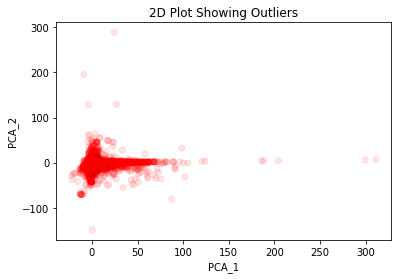

In [10]:
plt.scatter(samp['PCA_1'],samp['PCA_2'],c=samp['Class'],alpha=0.1, cmap='flag')
plt.title('2D Plot Showing Outliers')
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.show()

### Isolation Forest: Instantiating and Fitting

In [11]:
IsolationForest = IsolationForest(n_estimators=200, max_samples=len(X), contamination='auto', random_state=np.random.RandomState(42), verbose=0)
IsolationForest.fit(X)

IsolationForest(max_samples=170885, n_estimators=200,
                random_state=RandomState(MT19937) at 0x7F0092879240)

### Isolation Forest: Initial Evaluation

In [12]:
# establishes the mean anomaly score of the decision tree's average depth
scores_prediction = IsolationForest.decision_function(X)
y_pred = IsolationForest.predict(X)

In [13]:
# Producing a clssification report to examine the efficacy of this model.
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != y).sum()
# Run Classification Metrics
print("Classification Report")
print(f'Isolation Forest: {n_errors}')
print(f"Accuracy Score :{accuracy_score(y,y_pred)}")
print(classification_report(y,y_pred))

Classification Report
Isolation Forest: 458
Accuracy Score :0.9973198349767387
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    170525
           1       0.39      0.46      0.42       360

    accuracy                           1.00    170885
   macro avg       0.69      0.73      0.71    170885
weighted avg       1.00      1.00      1.00    170885



In [14]:
##### Building a Confusion Matrix To Get An Idea of How Well This Model Performs.

In [15]:
if_cm = confusion_matrix(y, y_pred)

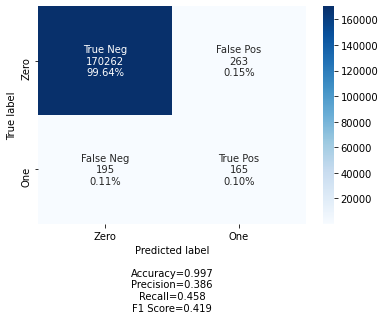

In [16]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(if_cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

### Initial Findings

While it seems I was able to achieve somewhat decent results from the model, confusion matrices are not well suited to this dataset nor to this domain since instances of fraud are generally much lower than the number of legitimate transactions. After conducting a bit more research into the evaluation of this algorithm I found that using confusion matrices, and even simple ROC curves to gauge model performance are subpar compared to model evaluation using the Area Under the Receiver Operating Characteristic (AUROC).

This evaluation method can handle highly imbalanced data. The higher the AUROC score the better, with a score of one being perfect and .5 being the worst. Additionally, I use the Area Under Recall Curve Precision Score (AUCPR) although that particular metric still isn't as capable as the AUC in dealing with imbalanced data.

Finally, I also make use of the H2O library, which provided strong documentation and an array of algorithms, including Isolation Forests, while also allowing for a simple implementation of the aforementioned evaluation methods.

In [17]:
hf = h2o.import_file("creditcard.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [18]:
IsolationForest2 = h2o.estimators.H2OIsolationForestEstimator(ntrees=100, seed=42)
IsolationForest2.train(x=hf.col_names[0:30], training_frame=hf)
predictions = IsolationForest2.predict(hf)

predictions

isolationforest Model Build progress: |███████████████████████████████████| 100%
isolationforest prediction progress: |████████████████████████████████████| 100%


predict,mean_length
0.0702247,6.75
0.0393258,6.86
0.199438,6.29
0.0561798,6.8
0.0786517,6.72
0.0365169,6.87
0.0393258,6.86
0.134831,6.52
0.101124,6.64
0.0421348,6.85


In [19]:
# from H2o Library
def get_auc(labels, scores):
    
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


def get_aucpr(labels, scores):
    precision, recall, th = precision_recall_curve(labels, scores)
    aucpr_score = np.trapz(recall, precision)
    return precision, recall, aucpr_score


def plot_metric(ax, x, y, x_label, y_label, plot_label, style="-"):
    ax.plot(x, y, style, label=plot_label)
    ax.legend()
    
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)


def prediction_summary(labels, predicted_score, predicted_class, info, plot_baseline=True, axes=None):
    if axes is None:
        axes = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]

    fpr, tpr, auc_score = get_auc(labels, predicted_score)
    plot_metric(axes[0], fpr, tpr, "False positive rate",
                "True positive rate", "{} AUC = {:.4f}".format(info, auc_score))
    if plot_baseline:
        plot_metric(axes[0], [0, 1], [0, 1], "False positive rate",
                "True positive rate", "baseline AUC = 0.5", "r--")

    precision, recall, aucpr_score = get_aucpr(labels, predicted_score)
    plot_metric(axes[1], recall, precision, "Recall",
                "Precision", "{} AUCPR = {:.4f}".format(info, aucpr_score))
    if plot_baseline:
        thr = sum(labels)/len(labels)
        plot_metric(axes[1], [0, 1], [thr, thr], "Recall",
                "Precision", "baseline AUCPR = {:.4f}".format(thr), "r--")

    plt.show()
    return axes

In [20]:
##### Using the .90th Quantile to Establish a Threshold.
quantile = 0.9
quantile_frame = predictions.quantile([quantile])
quantile_frame

Probs,predictQuantiles,mean_lengthQuantiles
0.9,0.134831,6.99


In [21]:
threshold = quantile_frame[0, "predictQuantiles"]
predictions["predicted_class"] = predictions["predict"] > threshold
predictions["class"] = hf["Class"]
predictions

predict,mean_length,predicted_class,class
0.0702247,6.75,0,0
0.0393258,6.86,0,0
0.199438,6.29,1,0
0.0561798,6.8,0,0
0.0786517,6.72,0,0
0.0365169,6.87,0,0
0.0393258,6.86,0,0
0.134831,6.52,0,0
0.101124,6.64,0,0
0.0421348,6.85,0,0


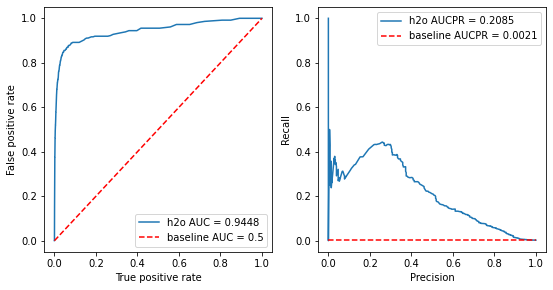

In [22]:
%matplotlib inline
def figure():
    fig_size = 4.5
    f = plt.figure()
    
    f.set_figheight(fig_size)
    f.set_figwidth(fig_size*2)

h2o_predictions = predictions.as_data_frame()

figure()
axes = prediction_summary(
    h2o_predictions["class"], h2o_predictions["predict"], h2o_predictions["predicted_class"], "h2o")

## Exploring Other Commonly Used Algorithms

While the Isolation Forest algorithm is indeed well suited for finding outliers I wanted to test its performance against a few other algorithms I've worked with, namely logistic regression and another forest-based algorithm, random forest. I chose LR because it is a foundational algorithm that would work well on this particular dataset. In the case of random forest, I wanted to contrast the conceptual/intuitive difference between the Isolation Forest method of selecting random splits to find the leaves that isolate fastest relative to the average depth and isolation to a normal random forests classification model.


For these two algorithms, the data must be treated a little differently. First, I drop the 'Time' column as it is unnecessary in this particular case. Second, I employ a test-train split. Although I'm using the exact same data, I want to maintain a good practice of simply calling the data again into a new pandas data frame.


### Logistic Regression

In [23]:
df2 = pd.read_csv('creditcard.csv')
df2.drop('Time', axis = 1, inplace = True)
X2 = df2.iloc[:, 0:-1]
y2 = df2['Class']

col=[col for col in df2.columns if col not in ['Time','Class']]

for i in col:
    scaled=RobustScaler()
    df2[i]=scaled.fit_transform(df2[i].values.reshape(-1,1))

X = df2.iloc[:, 1:-1]


X_train, X_test, y_train, y_test = train_test_split(X2, y2, train_size = 0.8, test_size = 0.2, random_state = 42)

In [24]:
log_reg = LogisticRegression(max_iter=20000,random_state=42)
log_reg.fit(X_train, y_train)
lr_y_predict = log_reg.predict(X_test)

#### Logistic Regression: Evaluation

In [25]:
lr_cm = confusion_matrix(y_test, lr_y_predict, labels = [0, 1])

In [26]:
def confusion_matrices(cm,classes=None, title='Confusion Matrix'):
    sns.heatmap(cm, xticklabels=['1','0'], yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})


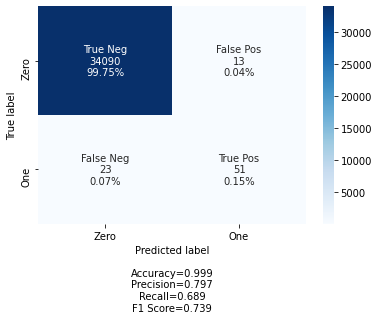

In [27]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(lr_cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

### Random Forest

In [28]:
df3 = pd.read_csv('creditcard.csv')
df3.drop('Time', axis = 1, inplace = True)
X3 = df3.iloc[:, 0:-1]
y3 = df3['Class']

col=[col for col in df3.columns if col not in ['Time','Class']]

for i in col:
    scaled=RobustScaler()
    df3[i]=scaled.fit_transform(df3[i].values.reshape(-1,1))

X = df3.iloc[:, 1:-1]

X_train, X_test, y_train, y_test = train_test_split(X3, y3, train_size = 0.8, test_size = 0.2, random_state = 42)


rf = RandomForestClassifier(max_depth = 4)
rf.fit(X_train, y_train)
rf_yhat = rf.predict(X_test)

In [29]:
rf_cm = confusion_matrix(y_test, rf_yhat, labels = [0, 1])

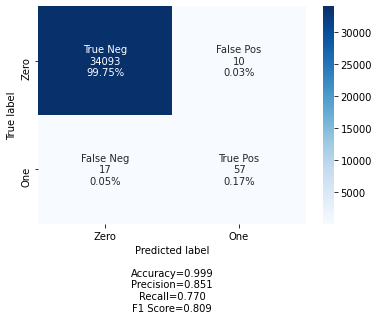

In [30]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(rf_cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')